In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [146]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [147]:
# building the vocabulary and creating stoi and itos array
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [148]:
# building the dataset
block_size = 3
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
    

In [149]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [150]:
print(X.shape)
Y.shape

torch.Size([228146, 3])


torch.Size([228146])

In [151]:
# LOOK UP TABLE
C = torch.randn((27,2))
emb = C[X]
print(X[1,2])
print(C[X][1,2])
print(C[5])
print(emb.shape)


tensor(5)
tensor([0.9433, 1.5486])
tensor([0.9433, 1.5486])
torch.Size([228146, 3, 2])


In [152]:
# HIDDEN LAYER
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [153]:
# 32, 6 @ 6, 100 -> 32, 100
h.shape

torch.Size([228146, 100])

In [154]:
# OUTPUT LAYER
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [155]:
parameters = [C, W1, b1, W2, b2]
logits = h @ W2 + b2
# CLASSIFICATION (THIS IS NOT OPTIMAL AS IT CREATES MULTIPLE TENZORS IN MEMORY ALSO BACKWARD PASS BECOMES OPTIMIZED)
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss


tensor(17.3593)

### PUTTING IT ALL TOGETHER

In [156]:
# SETTING UP THE CORRECT LEARNING RATE
# WE DETERMINE LEARNING RATE IS BETWEEN -0.001 AND 1
lre = torch.linspace(-3, 0, 1000) # creates 1000 numbers between -3 and 0
lrs = 10**lre 

In [163]:
for p in parameters:
    p.requires_grad = True

lri=[]
lossi=[]
for i in range(10000):
    # mini batch construct
    ix = torch.randint(0, len(X), (32,))
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
   
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lr)
    lossi.append(loss.item())
print(loss.item())

1.8843756914138794


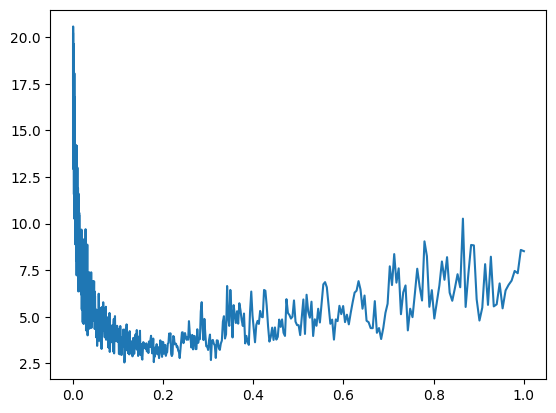

In [158]:
plt.plot(lri, lossi)

In [145]:
# THIS TAKES A LOT OF TIME SO LETS DO IT IN BATCHES
torch.randint(0, 5, (32,))
# THIS WILL GIVE RANDOM 32 NUMBERS BETWEEN 1 AND 5
# WE NEED IT ON OUR DATA SET
torch.randint(0, X.shape[0], (32,))

tensor([226830, 211242, 160722, 187010,  88230,  89177, 136540, 208620,  88291,
        192638,  53200, 107946, 184296,  60324, 193389, 176912, 181043,  90022,
        197557, 225549, 172543, 148682,  72519,  14104,  52158,  31009, 122735,
        217222,  53484, 156842,  86247, 217285])

In [164]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3127, grad_fn=<NllLossBackward0>)

### SPLITTING THE DATA INTO TRAINING, VALIDATION AND TEST

In [165]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

### MLP MODEL FOR THE TRAINING

In [189]:
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [190]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [191]:
sum(p.nelement() for p in parameters)

10281

In [192]:
for p in parameters:
    p.requires_grad = True

In [202]:
for p in parameters:
    p.requires_grad = True

lri=[]
lossi=[]
stepi=[]
for i in range(30000):
    # mini batch construct
    ix = torch.randint(0, len(Xtr), (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
   
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lr)
    lossi.append(loss.item())
    stepi.append(i)
print(loss.item())

2.121220588684082


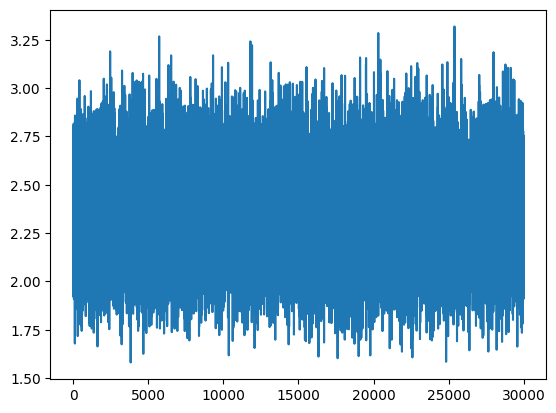

In [203]:
plt.plot(stepi, lossi)

In [204]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3900, grad_fn=<NllLossBackward0>)

In [205]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3917, grad_fn=<NllLossBackward0>)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

junide.
jana.
adhu.
huna.
edin.
kei.
rito.
sham.
gee.
hulania.
yan.
leveni.
dedeilewi.
bres.
jaie.
yva.
ter.
aveum.
haf.
etum.
